In [21]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from ast import literal_eval
import os
import itertools

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV, LinearRegression

from sklearn.preprocessing import MinMaxScaler

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# data_length = 10000 # TODO: not used
plot_dir = 'results_additional_features_all'
stocks = list(roc_results.results_10000.keys())

In [11]:
def rescale(df):
    scaler = MinMaxScaler()
    df[['mid_price']] = scaler.fit_transform(df[['mid_price']])
    for c in [c for c in df.columns if 'prev' in c or 'next' in c]:
        df[[c]] = scaler.transform(df[[c]])
    return df

def svc(clf, df, df_cv, columns):
    df = rescale(df)
    df_cv = rescale(df_cv)
    X = df[columns]
    y = df['mid_price_indicator']
    clf.fit(X, y)
    pred = clf.predict(X)
    pred_cv = clf.predict(df_cv[columns])
    return roc_auc_score(y, pred), roc_auc_score(df_cv['mid_price_indicator'], pred_cv)

In [50]:
def plot_results(clf, df, df_cv, plot_title='', stock=None):
    x_columns = {}
    nums = [2, 5, 10, 20, 50]
    x_columns['queue_imb'] = [c for c in df.columns if 'queue_im'  in c]
    for n in nums:
        x_columns['prev_{}'.format(n)] = [
            c for c in df.columns if 'prev_mid_price_avg_{}'.format(n) == c]
        x_columns['prev_{}_and_imb'.format(n)] = [
            c for c in df.columns if 'prev_mid_price_avg_{}'.format(n) == c or 'queue_im' in c]
    results = []
    titles = []
    
    for features, x_cols in x_columns.items():
        res = svc(clf, df, df_cv, x_cols)
        titles.append(features)
        results.append({'train': res[0], 'cv': res[1], 'stock': stock, 'features': features})
    df_res = pd.DataFrame(results, index=titles)
    df_res[['train', 'cv']].plot(kind='bar')

    plt.legend(loc='lower left')
    plt.ylim(0, 1)
    plt.title(plot_title)
    plt.savefig(os.path.join(plot_dir, '{}_{}.png'.format(stock, plot_title)))
    return results

In [51]:
%%capture
results = []
for stock in stocks:
    df, df_cv, df_test = lob.load_prepared_data(
        stock, data_dir='../queue_imbalance/data/avg_mid_bool/', cv=True, include_test=True, length=None)
    df.dropna(inplace=True)
    df_cv.dropna(inplace=True)
    df_test.dropna(inplace=True)
    df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
    df.index = df['datetime']
    df = df.sort_index()

    title = 'Logistic Regression for {}'.format(stock)
    print(title)
    clf = LogisticRegressionCV()
    result = plot_results(clf, df, df_cv, plot_title=title, stock=stock)
    results += result
df_res = pd.DataFrame(results)
df_res.to_csv('{}/results.csv'.format(plot_dir))

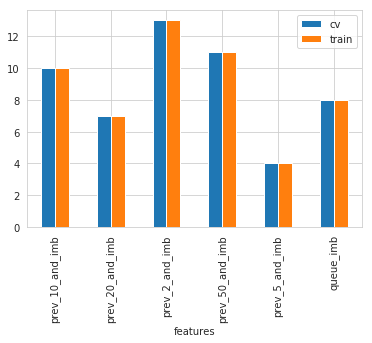

In [52]:
df_res.sort_values(by='cv', ascending=False).groupby('stock').first().groupby(
    'features').count().plot(kind='bar')

In [53]:
df_best = df_res.sort_values(by='cv', ascending=False).groupby('stock').first()
best_features = list(df_best.groupby('features').count().nlargest(10, 'cv').index)

In [55]:
df_compare = df_res.sort_values(by=['stock', 'cv'], ascending=False).groupby('stock').head(
    len(df_res['features'].unique()))
results = []
feature_combinations = list(itertools.combinations(list(range(len(best_features))), 2))
for s in stocks:
    r = {'stock': s}
    for comb in feature_combinations:
        df_stock = df_compare[df_compare['stock'] == s]
        a = df_stock[df_compare['features'] == best_features[comb[0]]]['cv'].values[0]
        b = df_stock[df_compare['features'] == best_features[comb[1]]]['cv'].values[0]
        r['{} vs {} cv'.format(best_features[comb[0]], best_features[comb[1]])] = a-b
        r['{} vs {} cv'.format(best_features[comb[1]], best_features[comb[0]])] = b-a
    results.append(r)

df_s = pd.DataFrame(results)
#df_s.plot(figsize=(16, 16))
df_s[[c for c in df_s.columns if 'vs queue_imb' in c]].describe()
        

,prev_10_and_imb vs queue_imb cv,prev_20_and_imb vs queue_imb cv,prev_2_and_imb vs queue_imb cv,prev_50_and_imb vs queue_imb cv,prev_5_and_imb vs queue_imb cv
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.000896,0.000729,0.000637,0.000642,0.000628
std,0.002486,0.002649,0.001919,0.002635,0.001990
min,-0.003517,-0.005906,-0.003188,-0.005906,-0.003365
25%,-0.000612,-0.000584,-0.000634,-0.000713,-0.000634
50%,0.000707,0.000634,0.000587,0.000487,0.000707
75%,0.001657,0.001548,0.001662,0.001483,0.001718
max,0.014265,0.013468,0.005169,0.013448,0.005169
